<img src="svds/logo_large.jpg" alt="SVDS" width="590" align="left">

# Imbalanced Learning with Gaussians

## Tom Fawcett / Silicon Valley Data Science / May 2016
tom@svds.com

This notebook ([click here for `.ipynb` file](https://github.com/silicon-valley-data-science/learning-from-imbalanced-classes/blob/master/Gaussians.ipynb)) illustrates several approaches to the same problem: learning a classifier that can separate examples from two slightly overlapping Gaussians.  This notebook shows the effects of undersampling, oversampling, and class weight adjustment.

(Bits and pieces of this code were taken from everywhere, including the scikit-learn examples.  Little of it is mine; I mostly stitched it together.)

In [10]:
# The usual imports

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

from numpy.random import normal, shuffle
from sklearn.linear_model import LogisticRegression

from ipywidgets import interact, IntSlider
from IPython.display import display

Create two one-dimensional arrays sampled from Gaussians.  Both have standard deviation of 1.0.  The first is centered at x=1 and the second at x=2.

In [2]:
mu1 = 1
sigma1 = 0.3
mu2 = 2
sigma2 = 0.3

p1_all = normal(loc=mu1, scale=sigma1, size=200)
p2_all = normal(loc=mu2, scale=sigma2, size=200)
# Create linear spaces spanning out to 3 sigma on each side.
linspace1 = np.linspace(mu1-3*sigma1, mu1+3*sigma1, 200)
linspace2 = np.linspace(mu2-3*sigma2, mu2+3*sigma2, 200)

This is the main driver function.  It plots the two gaussians and the points on the _x_ axis.  Below you can choose the number of class1 and class2 examples used, as well as the number of random samples retrieved.  Each separating line is shown as a black vertical line.

In [3]:
def plot_samples(class1_examples, class2_examples, samples):
    plt.clf()
    # Plot the Gaussians
    plt.plot(linspace1, 1/(sigma1 * np.sqrt(2 * np.pi)) *
                np.exp( - (linspace1 - mu1)**2 / (2 * sigma1**2) ),
          linewidth=2, color='b', label="Class 1")
    plt.plot(linspace2, 1/(sigma1 * np.sqrt(2 * np.pi)) *
                np.exp( - (linspace2 - mu2)**2 / (2 * sigma1**2) ),
          linewidth=2, color='r', label="Class 2 (majority)")
    for _ in range(samples):
        # Shuffle the examples then trim them to the number desired
        shuffle(p1_all)
        shuffle(p2_all)
        p1 = p1_all[:class1_examples]
        p2 = p2_all[:class2_examples]
        X = np.append(p1, p2)
        y = np.append([0] * len(p1), [1] * len(p2))
        # Train Logistic Regression on X and y
        lr = LogisticRegression(fit_intercept=True, intercept_scaling=1, solver="sag")
        lr.fit(X.reshape(-1,1), y)
        # Plot the examples
        plt.plot(p1, np.zeros(len(p1)), marker="o", markersize=7, color="b")
        plt.plot(p2, np.zeros(len(p2)), marker="o", markersize=7, color="r")
        # Now draw the boundary line found by LR.  We don't care about the slope of the LR line.
        # Just drop a vertical line through each x intercept.
        x_weight = lr.coef_[0][0]
        y_intercept = lr.intercept_[0]
        x_intercept = -y_intercept / x_weight
        plt.plot([x_intercept,x_intercept], [0,2], color="black")
    plt.legend()
    plt.xlim(0,3)
    plt.ylim(-0.1, 1.6)
    plt.show()

# Interactive experiment -- undersampling

Below you can play with sampling these distributions by moving the sliders.  Each **sample** is one draw of examples from each class, followed by the generation of a separating line based on those examples.  **class1** and **class2_examples** determine how many examples are pulled from each class for one sample.

In general, the more balanced the examples are, the closer the vertical lines should be to the ideal split point (where the Gaussians cross).  The more examples you have the narrower the band of separators should be, though there will still be some variance even at the highest (n=100) values.  Note that this is **always** undersampling, never oversampling.

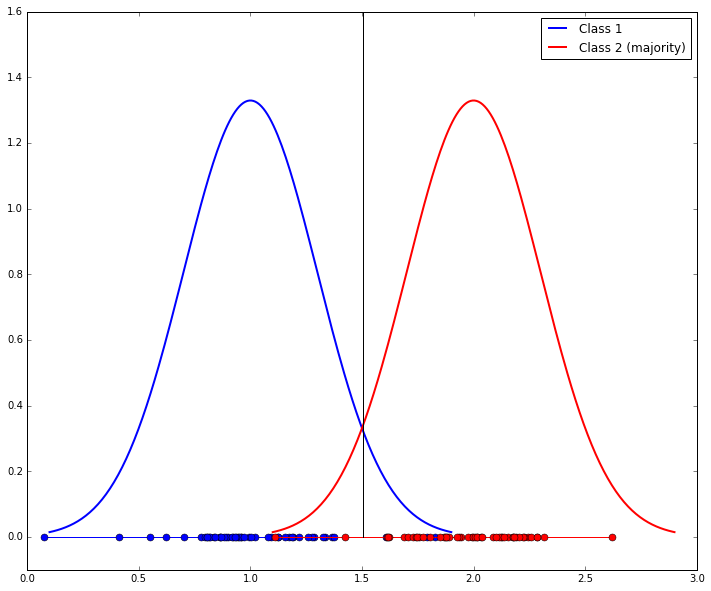

In [4]:
v = interact(plot_samples, class1_examples=(5,100,5), class2_examples=(5,100,5), samples=(1,20))
display(v)

# Oversampling

This shows the same problem as above but addressed with **oversampling** (replicating minority instances).  As the slider below is moved, the minority instances are randomly duplicated.  This mostly has the effect of increasing the penalties for false positives (false classifications of the minority instances).

In [5]:
minority_all = normal(loc=mu1, scale=sigma1, size=10)
majority_all = normal(loc=mu2, scale=sigma2, size=100)

def plot_samples_oversampling(n_minority_exs=len(minority_all)):
    plt.clf()
    plt.plot(linspace1, 1/(sigma1 * np.sqrt(2 * np.pi)) *
                np.exp( - (linspace1 - mu1)**2 / (2 * sigma1**2) ),
          linewidth=2, color='b', label="Class 1 (minority)")
    plt.plot(linspace2, 1/(sigma1 * np.sqrt(2 * np.pi)) *
                np.exp( - (linspace2 - mu2)**2 / (2 * sigma1**2) ),
          linewidth=2, color='r', label="Class 2 (majority)")
    minority_exs = np.concatenate([minority_all for _ in 
                              range(0, int(n_minority_exs/len(minority_all))+1)][:n_minority_exs])
    X = np.append(minority_exs, majority_all)
    y = np.append([0] * len(minority_exs), [1] * len(majority_all))
    lr = LogisticRegression(fit_intercept=True, intercept_scaling=1, solver="sag")
    lr.fit(X.reshape(-1,1), y)
    plt.plot(minority_exs, np.zeros(len(minority_exs)), marker="o", markersize=7, color="b")
    plt.plot(majority_all, np.zeros(len(majority_all)), marker="o", markersize=7, color="r")
    x_weight = lr.coef_[0][0]
    y_intercept = lr.intercept_[0]
    x_intercept = -y_intercept / x_weight
#        print("X weight =", x_weight, ", Y intercept = ", y_intercept, ", X intercept =", x_intercept)
    plt.title("Minority sampled %0.1f" % (n_minority_exs/len(minority_all)))
    plt.plot([x_intercept,x_intercept], [0,2], color="black")
     #   plt.plot([0,2],[y_intercept,2*x_weight+y_intercept])
    plt.legend()
    plt.xlim(0,3)
    plt.ylim(-0.1, 1.6)
    plt.show()


# Interactive experiment -- oversampling

As the slider below is moved, the minority instances are randomly duplicated. 

This mostly has the effect of increasing the penalties for false positives (false classifications of the minority instances).

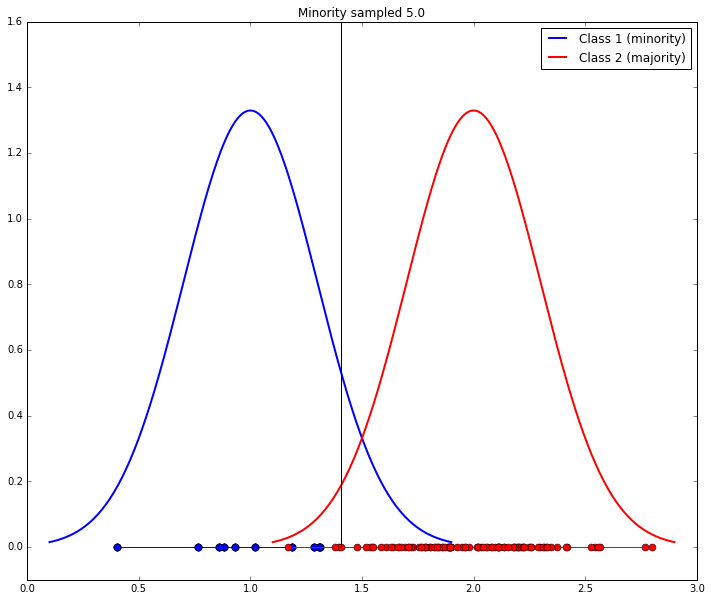

In [6]:
v = interact(plot_samples_oversampling, 
             n_minority_exs=(len(minority_all), len(majority_all)))
display(v)

# Class Weights


In [8]:
def plot_samples_class_weights(minority_weight=1.0):
    plt.clf()
    plt.plot(linspace1, 1/(sigma1 * np.sqrt(2 * np.pi)) *
                np.exp( - (linspace1 - mu1)**2 / (2 * sigma1**2) ),
          linewidth=2, color='b', label="Class 1 (minority)")
    plt.plot(linspace2, 1/(sigma1 * np.sqrt(2 * np.pi)) *
                np.exp( - (linspace2 - mu2)**2 / (2 * sigma1**2) ),
          linewidth=2, color='r', label="Class 2 (majority)")
    X = np.append(minority_all, majority_all)
    y = np.append([0] * len(minority_all), [1] * len(majority_all))
    lr = LogisticRegression(fit_intercept=True, intercept_scaling=1, solver="sag", 
                            class_weight = { 0: minority_weight})
    lr.fit(X.reshape(-1,1), y)
    plt.plot(minority_all, np.zeros(len(minority_all)), marker="o", markersize=7, color="b")
    plt.plot(majority_all, np.zeros(len(majority_all)), marker="o", markersize=7, color="r")
    x_weight = lr.coef_[0][0]
    y_intercept = lr.intercept_[0]
    x_intercept = -y_intercept / x_weight
    plt.title("Minority weight %0.1f" % (minority_weight,))
    plt.plot([x_intercept,x_intercept], [0,2], color="black")
     #   plt.plot([0,2],[y_intercept,2*x_weight+y_intercept])
    plt.legend()
    plt.xlim(0,3)
    plt.ylim(-0.1, 1.6)
    plt.show()


# Interactive experiment -- altering class_weights

Finally, here's the same problem addressed by varying the minority class's weight passed to the logistic regression algorithm. The slider directly determines the `class_weight` parameter value.

You may notice as you increase `class_weight` of the minority class, the separating line does not move smoothly through the region --- it sometimes jumps around unpredictably.

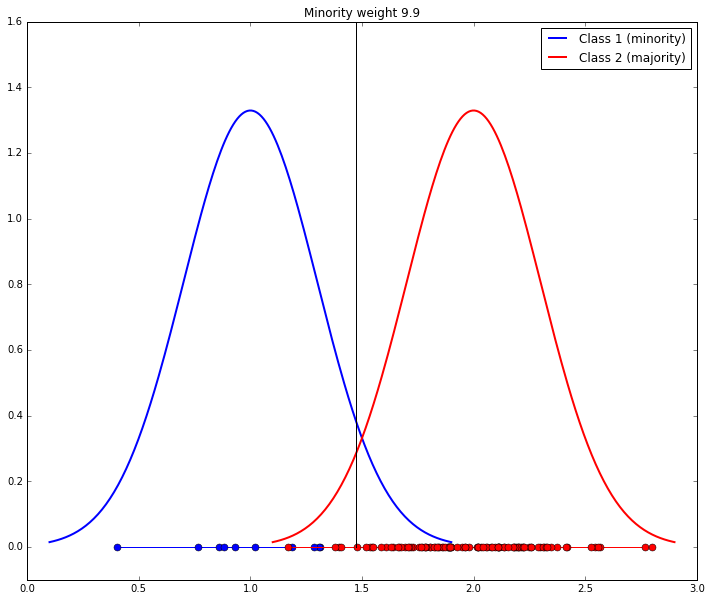

In [9]:
v = interact(plot_samples_class_weights, 
             minority_weight=(1.0, 100.0))
display(v)

# End

<center><h2>© <a href="www.svds.com">2016 Silicon Valley Data Science LLC</a></h2></center>